# For any modifications, initially use this notebook as a starting point. Duplicate the notebook and start from there.

Imports

In [1]:
import os
from tqdm import tqdm
from typing import Generator, List, Optional, Tuple

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from torchvision.datasets import CIFAR10

Constants


In [2]:
MAX_ITERATIONS: int = 10000
WINDOW: Tuple[int, int] = (32, 32)
HOG: str = "sk" # cv2 or sk
N_DIMENSIONS = 100

# SVC Model

LFW dataset loading (positive class)

In [3]:
def load_lfw_positive_images(target_size: Tuple[int, int] = WINDOW) -> np.ndarray:
    """
    Loads the LFW dataset, extracts positive images, and resizes them to the target size.

    :param target_size: The target size (width, height) for resizing the images.
    :return: A tuple containing the NumPy array of resized positive images and the count of positive images.
    """
    lfw = fetch_lfw_people(
        color=True,
        funneled=True,
        resize=1.0
    )

    pos_img: np.ndarray = np.array([cv2.resize(img, target_size) for img in lfw.images])

    return pos_img

CIFAR-10 dataset loading (negative class)

In [4]:
def load_cifar10_negative_images(data_path: str = './data/cifar10', target_size: Tuple[int, int] = WINDOW) -> np.ndarray:
    """
    Loads the CIFAR-10 dataset, resizes images to the target size, and extracts negative images
    from both training and test datasets as a single NumPy array.

    :param data_path: Path to download and store the CIFAR-10 dataset.
    :param target_size: The target size (width, height) for resizing the images.
    :return: A NumPy array of resized negative images.
    """
    cifar10_train = CIFAR10(
        root=data_path,
        train=True,
        download=True
    )
    cifar10_test = CIFAR10(
        root=data_path,
        train=False,
        download=True
    )

    neg_img_train: np.ndarray = np.array([
        cv2.resize(np.array(img), target_size) for img, _ in cifar10_train
    ])
    neg_img_test: np.ndarray = np.array([
        cv2.resize(np.array(img), target_size) for img, _ in cifar10_test
    ])

    neg_img = np.concatenate((neg_img_train, neg_img_test), axis=0)

    return neg_img

HOG feature extraction (skimage implementation is slow but works well, CV2 is fast but doesn't work well)

In [5]:
def extract_hog_features_cv2(image: np.ndarray,
                         pixels_per_cell: Tuple[int, int] = (8, 8),
                         cells_per_block: Tuple[int, int] = (2, 2),
                         orientations: int = 9) -> np.ndarray:
    """
    Extract HOG (Histogram of Oriented Gradients) features using OpenCV's implementation.

    :param image: The input image as a NumPy array. If color, will be converted to grayscale.
    :param pixels_per_cell: The size of each cell in pixels (width, height).
    :param cells_per_block: The number of cells per block (width, height).
    :param orientations: The number of orientation bins for the histograms.
    :return: The HOG feature vector as a NumPy array.
    """
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image_uint8 = image.astype(np.uint8)

    win_size = image_uint8.shape[::-1]
    block_size = (cells_per_block[1] * pixels_per_cell[1],
                  cells_per_block[0] * pixels_per_cell[0])
    block_stride = (pixels_per_cell[1], pixels_per_cell[0])
    cell_size = (pixels_per_cell[1], pixels_per_cell[0])

    hog = cv2.HOGDescriptor(_winSize=win_size,
                            _blockSize=block_size,
                            _blockStride=block_stride,
                            _cellSize=cell_size,
                            _nbins=orientations)

    features = hog.compute(image_uint8)
    return features.flatten()

def extract_hog_features_sk(image: np.ndarray,
                         pixels_per_cell: Tuple[int, int] = (8, 8),
                         cells_per_block: Tuple[int, int] = (2, 2),
                         orientations: int = 9) -> np.ndarray:
    """
    Extracts HOG (Histogram of Oriented Gradients) descriptors from an image.

    :param image: The input image as a NumPy array.
    :param pixels_per_cell: The size of each cell in pixels (width, height).
    :param cells_per_block: The number of cells per block (width, height).
    :param orientations: The number of orientation bins for the histograms.
    :return: The HOG feature vector as a NumPy array.
    """
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(image, orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys', visualize=True)

    return features

def extract_hog_features(image: np.ndarray,
                         pixels_per_cell: Tuple[int, int] = (8, 8),
                         cells_per_block: Tuple[int, int] = (2, 2),
                         orientations: int = 9) -> np.ndarray:
    if HOG == "cv2":
        return extract_hog_features_cv2(image, pixels_per_cell, cells_per_block, orientations)
    elif HOG == "sk":
        return extract_hog_features_sk(image, pixels_per_cell, cells_per_block, orientations)
    else:
        raise ValueError("Invalid HOG extraction method. Use 'cv2' or 'sk'.")

Loading the dataset

In [6]:
def load_dataset() -> Tuple[np.ndarray, np.ndarray]:
    """
    Load dataset with HOG feature extraction and shuffle the data.
    If the dataset is already saved as a Parquet file, it loads the data from there.

    :return: A tuple containing the shuffled feature matrix (data_X) and the label vector (labels_y).
    """

    parquet_path = f'data/train/dataset{str(WINDOW[0])}{HOG}.parquet'

    if os.path.exists(parquet_path):
        df = pd.read_parquet(parquet_path, engine="pyarrow")
        labels_y = df['label'].to_numpy(dtype=np.int32)
        data_X = df.drop(columns=['label']).to_numpy(dtype=np.float32)

        print(f"Data loaded from {parquet_path}")
        return data_X, labels_y

    print("Generating dataset...")

    positive_images: np.ndarray = load_lfw_positive_images(target_size=WINDOW)
    negative_images: np.ndarray = load_cifar10_negative_images()

    total_images = len(positive_images)+ len(negative_images)
    feature_length = len(extract_hog_features(positive_images[0]))

    data_X = np.zeros((total_images, feature_length), dtype=np.float32)
    labels_y = np.zeros(total_images, dtype=np.int32)

    n_pos = len(positive_images)
    labels_y[:n_pos] = 1

    for i, img in enumerate(tqdm(positive_images, desc="Positive class", unit="img")):
        data_X[i] = extract_hog_features(img)

    for i, img in enumerate(tqdm(negative_images, desc="Negative class", unit="img")):
        data_X[i + n_pos] = extract_hog_features(img)

    indices = np.random.permutation(total_images)
    data_X = data_X[indices]
    labels_y = labels_y[indices]

    os.makedirs(os.path.dirname(parquet_path), exist_ok=True)
    df = pd.DataFrame(data_X)
    df['label'] = labels_y
    df.to_parquet(parquet_path, index=False)
    print(f"Dataset saved to {parquet_path}")

    return data_X, labels_y

In [7]:
X: np.ndarray
Y: np.ndarray
X, Y = load_dataset()
print("Dataset size:", X.shape, Y.shape)

Data loaded from data/train/dataset32sk.parquet...
Dataset size: (73233, 324) (73233,)


Standard Scaling and Dimensionality Reduction (PCA)

In [8]:
scaler: StandardScaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reducer: PCA = PCA(n_components=N_DIMENSIONS)
X_reduced: np.ndarray = reducer.fit_transform(X_scaled)

print("Reduced dataset size:", X_reduced.shape)

Reduced dataset size: (73233, 100)


Training the SVC (if already trained, it can be loaded from the commented line)

In [9]:
if not os.path.exists("models"):
    os.makedirs("models")

filename: str = f"models/PCA{WINDOW[0]}{HOG}{N_DIMENSIONS}.joblib"

In [10]:
# svc: SVC = joblib.load(filename)

svc: SVC = SVC(kernel="rbf", max_iter=MAX_ITERATIONS)
svc.fit(X_reduced, Y)

joblib.dump(svc, filename)

pred_train: np.ndarray = svc.predict(X_reduced)
print("Classification report (training data):")
print(classification_report(Y, pred_train))

Classification report (training data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60000
           1       1.00      0.99      0.99     13233

    accuracy                           1.00     73233
   macro avg       1.00      0.99      1.00     73233
weighted avg       1.00      1.00      1.00     73233



# Face detection pipeline

Image pyramid generator, for image scaling

In [11]:
def image_pyramid(image: np.ndarray, scale: float = 1.5, minSize: Tuple[int, int] = WINDOW) -> Generator[np.ndarray, None, None]:
    """
    Generates an image pyramid.

    :param image: The original image as a NumPy array.
    :param scale: The scaling factor for resizing the image.
    :param minSize: The minimum size (width, height) at which resizing stops.
    :yield: The resized image as a NumPy array.
    """
    yield image
    while True:
        w: int = int(image.shape[1] / scale)
        h: int = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

Sliding window generator, for extracting patches from the image

In [12]:
def sliding_window(image: np.ndarray, stepSize: int, windowSize: Tuple[int, int]) -> Generator[Tuple[int, int, np.ndarray], None, None]:
    """
    Iterates over an image with a sliding window.

    :param image: The image to iterate over as a NumPy array.
    :param stepSize: The step size for moving the window.
    :param windowSize: The size of the window (width, height).
    :yield: The coordinates (x, y) and the extracted patch as a NumPy array.
    """
    for y in range(0, image.shape[0] - windowSize[1] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[0] + 1, stepSize):
            yield x, y, image[y:y + windowSize[1], x:x + windowSize[0]]

Non-Maximum Suppression (NMS)

In [13]:
def non_max_suppression(boxes: List[Tuple[int, int, int, int]], overlapThresh: float = 0.3) -> List[Tuple[int, int, int, int]]:
    if len(boxes) == 0:
        return []

    boxes_np = np.array(boxes)
    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = x1 + boxes_np[:, 2]
    y2 = y1 + boxes_np[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    indexes = np.argsort(areas)[::-1]

    picked = []
    while len(indexes) > 0:
        i = indexes[0]
        picked.append(i)

        xx1 = np.maximum(x1[i], x1[indexes[1:]])
        yy1 = np.maximum(y1[i], y1[indexes[1:]])
        xx2 = np.minimum(x2[i], x2[indexes[1:]])
        yy2 = np.minimum(y2[i], y2[indexes[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        overlap = (w * h) / areas[indexes[1:]]
        indexes = np.delete(indexes, np.concatenate(([0], np.where(overlap > overlapThresh)[0] + 1)))

    return [boxes[i] for i in picked]

Detection function

In [14]:
def detect_faces(image: np.ndarray,
                 svm: SVC,
                 scl: StandardScaler,
                 rdc: PCA,
                 window_size: Tuple[int, int] = WINDOW,
                 stepSize: int = 16,
                 scale: float = 1.5) -> List[Tuple[int, int, int, int]]:
    detections: List[Tuple[int, int, int, int]] = []
    for im_scaled in image_pyramid(image, scale=scale, minSize=window_size):
        scale_factor: float = image.shape[0] / im_scaled.shape[0]
        for (x, y, window) in sliding_window(im_scaled, stepSize, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            features: np.ndarray = extract_hog_features(window)
            features_scaled: np.ndarray = scl.transform(features.reshape(1, -1))
            features_reduced: np.ndarray = rdc.transform(features_scaled)
            prediction: np.ndarray = svm.predict(features_reduced)
            if prediction == 1:
                detections.append((int(x * scale_factor), int(y * scale_factor),
                                   int(window_size[0] * scale_factor), int(window_size[1] * scale_factor)))

    return non_max_suppression(detections, overlapThresh=0.3)


Visualization function

In [15]:
def visualize_face_detections(test_image_path: str,
                              svm: SVC,
                              scl: StandardScaler,
                              rdc: PCA,
                              stepSize: int = 16,
                              scale: float = 1.5) -> None:
    """
    Visualizes face detections on a test image using a trained SVM models.

    :param test_image_path: Path to the test image.
    :param svm: A trained SVC models for face detection.
    :param stepSize: The step size for the sliding window.
    :param scale: The scaling factor for the image pyramid.
    """
    test_image: Optional[np.ndarray] = cv2.imread(test_image_path)
    if test_image is not None:
        detections = detect_faces(test_image, svm, stepSize=stepSize, scale=scale, scl=scl, rdc=rdc)

        for (x, y, w, h) in detections:
            cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
        plt.title("Face Detections")
        plt.axis("off")
        plt.show()
    else:
        print("Test image not found.")

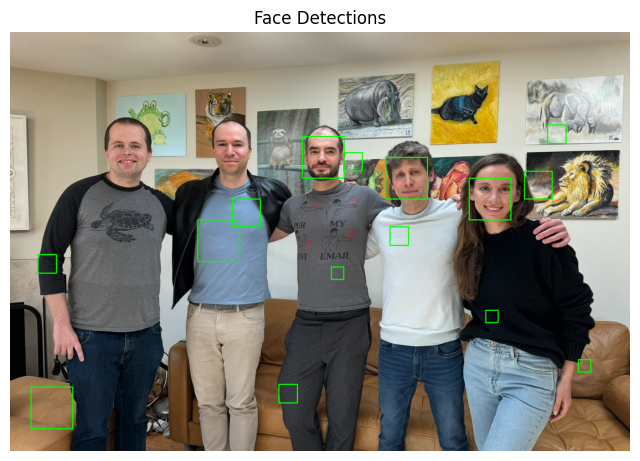

In [16]:
visualize_face_detections("data/test/test.jpg", svc, scaler, reducer)